# `PySal` Spatial Regression Models

In [74]:
from pysal.model import spreg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

We will use the following libraties from spacebench.

In [75]:
from spacebench import (
    SpaceEnv,
    SpaceDataset,
    DataMaster,
    DatasetEvaluator,
    EnvEvaluator,
)

Load the datamaster to list available datasets

In [76]:
DataMaster().list_datasets()

['healthd_dmgrcs_mortality_disc',
 'cdcsvi_limteng_hburdic_cont',
 'climate_relhum_wfsmoke_cont',
 'climate_wfsmoke_minrty_disc',
 'healthd_hhinco_mortality_cont',
 'healthd_pollutn_mortality_cont',
 'county_educatn_election_cont',
 'county_phyactiv_lifexpcy_cont',
 'county_dmgrcs_election_disc',
 'cdcsvi_nohsdp_poverty_cont']

Create the environment.

In [77]:
envname = "healthd_dmgrcs_mortality_disc"
env = SpaceEnv(envname, dir="downloads")
env.__dict__.keys()

dict_keys(['name', 'datamaster', 'api', 'dir', 'config', 'synthetic_data', 'metadata', 'graph', 'confounding_score_dict', 'smoothness_score_dict'])

Example of generating a dataset.

In [78]:
dataset = env.make()
print("treatment shape", dataset.treatment.shape)
print("covariates shape", dataset.covariates.shape)
print("num. edges", len(dataset.edges)) 
print("smoothness of missing confounder", dataset.smoothness_of_missing)
print("confounding of missing confounder", dataset.confounding_of_missing)


treatment shape (3109,)
covariates shape (3109, 30)
num. edges 9237
smoothness of missing confounder 0.8983694388901357
confounding of missing confounder 0.0030328993179644798


Now we use pySal models:

In [79]:
import libpysal as lp

In [80]:

W = lp.weights.full2W(dataset.adjacency_matrix()) 

In [88]:
treatment = dataset.treatment[:, None]
covariates = dataset.covariates
outcome = dataset.outcome

# make train matrix
trainmat = np.hstack([covariates, treatment])

In [89]:

model_gm_lag = spreg.GM_Lag(
    outcome,
    trainmat,
    w=W,
    name_y=dataset.outcome_name,
    name_x=dataset.covariates_names,
)

In [90]:
model_ml_lag = spreg.ML_Lag(
    outcome,
    trainmat,
    w=W,
    name_y=dataset.outcome_name,
    name_x=dataset.covariates_names,
)

/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/scipy/optimize/_minimize.py:892: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "
/Users/ant746/PycharmProjects/space/.venv/lib/python3.10/site-packages/spreg/ml_lag.py:608: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


In [91]:
print(model_gm_lag.name_z)

['CONSTANT', 'bin_NORTHEAST', 'bin_SOUTH', 'bin_WEST', 'cdc_mean_bmi', 'cdc_pct_cusmoker', 'cdc_pct_fmsmoker', 'cdc_pct_nnsmoker', 'cdc_pct_nvsmoker', 'cdc_pct_sdsmoker', 'cs_ed_below_highschool', 'cs_household_income', 'cs_median_house_value', 'cs_other', 'cs_population_density', 'cs_poverty', 'gmet_mean_rmn', 'gmet_mean_rmx', 'gmet_mean_sph', 'gmet_mean_summer_rmn', 'gmet_mean_summer_rmx', 'gmet_mean_summer_sph', 'gmet_mean_summer_tmmn', 'gmet_mean_tmmn', 'gmet_mean_tmmx', 'gmet_mean_winter_rmn', 'gmet_mean_winter_rmx', 'gmet_mean_winter_sph', 'gmet_mean_winter_tmmn', 'gmet_mean_winter_tmmx', 'qd_mean_pm25', 'W_cdc_mortality_pct']


In [93]:
print(model_ml_lag.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :cdc_mortality_pct                Number of Observations:        3109
Mean dependent var  :     21.2983                Number of Variables   :          33
S.D. dependent var  :      4.5544                Degrees of Freedom    :        3076
Pseudo R-squared    :      0.2552
Spatial Pseudo R-squared:  0.2514
Sigma-square ML     :      15.445                Log likelihood        :   -8667.417
S.E of regression   :       3.930                Akaike info criterion :   17400.835
                                                 Schwarz criterion     :   17600.222

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------

In [94]:
model_gm_lag.betas.shape

(33, 1)

Model shape je 33 zato sto ima coefs for: `constant`, `covariates` and `W_outcome`.

In [95]:
model_ml_lag.betas.shape

(33, 1)

## Predictions

In [96]:
# predict counterfactuals
tvals = dataset.treatment_values
counterfactuals_ml = []
counterfactuals_gl = []
for tval in tvals:
    trainmat = np.hstack(
        [np.ones(treatment.shape), 
         covariates, 
         np.full_like(treatment, tval),
         np.ones(treatment.shape)])
    counterfactuals_ml.append(
        np.dot(trainmat, model_ml_lag.betas)
    )
    counterfactuals_gl.append(
        np.dot(trainmat, model_gm_lag.betas)
    )
counterfactuals_ml = np.stack(counterfactuals_ml, axis=1)
counterfactuals_gl = np.stack(counterfactuals_gl, axis=1)

In [97]:
erf_ml = counterfactuals_ml.mean(0)
erf_gl = counterfactuals_gl.mean(0)

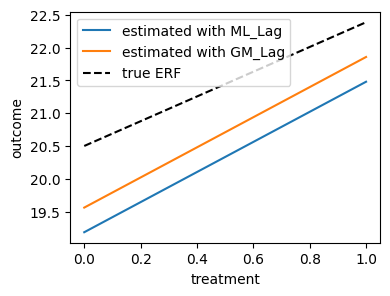

In [98]:
# plot comparing estimated and true erf
erf_true = dataset.erf()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(dataset.treatment_values, erf_ml, label="estimated with ML_Lag")
ax.plot(dataset.treatment_values, erf_gl, label="estimated with GM_Lag")
ax.plot(dataset.treatment_values, erf_true, label="true ERF", linestyle="--", color="k")
ax.set_xlabel("treatment")
ax.set_ylabel("outcome")
ax.legend();